In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install torchaudio soundfile librosa transformers lightgbm audiomentations tqdm

INFO: pip is looking at multiple versions of numpy-minmax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of numpy-rms to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 5.5 MB/s

# 📒 SHL Grammar Scoring Pipeline

## 1️⃣ Imports and Utility Setup

In [9]:
# Ignore warnings for readability
import os, gc, warnings
warnings.filterwarnings('ignore')

# Data science imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from tqdm.notebook import tqdm

# Audio imports
import librosa, librosa.display, soundfile as sf
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

# ML and deep learning
import torch
from transformers import Wav2Vec2Model, Wav2Vec2Processor

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor

## 2️⃣ Data Loading and Path Setup

In [10]:
# Set data paths (adjust if needed)
train_audio_dir = "/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train"
test_audio_dir  = "/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test"
train_csv = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/Dataset/train.csv')
test_csv = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/Dataset/test.csv')

# Standardize CSV schema to always have a 'file' column
if "filename" in train_csv.columns:
    train_df = train_csv.rename(columns={'filename':'file'})
else:
    train_df = train_csv
if "filename" in test_csv.columns:
    test_df = test_csv.rename(columns={'filename':'file'})
else:
    test_df = test_csv

print(train_df.head())
print("Label distribution (train):\n", train_df['label'].value_counts().sort_index())

             file  label
0   audio_710.wav    1.0
1  audio_1265.wav    1.0
2  audio_1114.wav    1.5
3   audio_946.wav    1.5
4  audio_1127.wav    2.0
Label distribution (train):
 label
1.0      2
1.5      2
2.0     44
2.5     26
3.0     51
3.5     19
4.0     82
4.5     68
5.0    150
Name: count, dtype: int64


## 3️⃣ Audio Preprocessing and Augmentation Functions

In [11]:
# Utility: Audio normalization and optional augmentations
def preprocess_audio(file_path, target_sr=16000, top_db=25):
    y, sr = sf.read(file_path)
    if len(y.shape) > 1:
        y = np.mean(y, axis=1)
    # Resample if needed
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    # Trim silence and normalize
    y, _ = librosa.effects.trim(y, top_db=top_db)
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))
    return y, sr

AUGMENT = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.3),
    TimeStretch(min_rate=0.9, max_rate=1.1, p=0.2),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.2),
    Shift(min_shift=-0.1, max_shift=0.1, p=0.2)
])

def augment_audio(y, sr):
    # Only applies during training with given probability
    return AUGMENT(samples=y.astype(np.float32), sample_rate=sr)

## 4️⃣ Feature Extraction Functions

In [12]:
# Acoustic (classic) features
def extract_acoustic_features(y, sr):
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y), axis=1)
    rms = np.mean(librosa.feature.rms(y=y), axis=1)
    ssc = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr), axis=1)
    return np.concatenate([mfccs, chroma, zcr, rms, ssc])  # 35 features

# Meta features (duration, energy, RMS, tempo)
def audio_meta_features(y, sr):
    duration = float(len(y)) / float(sr)
    energy = float(np.sum(y ** 2) / len(y))
    rms = float(np.sqrt(np.mean(y ** 2)))
    try:
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        if isinstance(tempo, (np.ndarray, list)):
            if np.shape(tempo) == (): tempo = float(tempo)
            elif len(tempo) > 0: tempo = float(tempo[0])
            else: tempo = 0.0
        else: tempo = float(tempo)
    except Exception:
        tempo = 0.0
    return np.array([duration, energy, rms, tempo], dtype=np.float32)

## 5️⃣ Wav2Vec2 Model Initialization

In [13]:
print("Loading pre-trained Wav2Vec2 model (this may take a minute)...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)
wav2vec_model.eval()

def extract_wav2vec_embeddings(y, sr):
    # Use Wav2Vec2 for deep embeddings (on GPU if available)
    with torch.no_grad():
        input_values = processor(
            y, sampling_rate=sr, return_tensors="pt", padding="longest"
        ).input_values.to(device)
        outputs = wav2vec_model(input_values)
        hidden_states = outputs.last_hidden_state.cpu().numpy()
        mean_embed = np.mean(hidden_states, axis=1).squeeze()
    return mean_embed  # 768d vector

Loading pre-trained Wav2Vec2 model (this may take a minute)...


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 6️⃣ Feature Building For All Data


In [14]:
def build_features(df, audio_dir, augment=False):
    feats, embeds, metas = [], [], []
    for fname in tqdm(df['file'], desc=f'Extracting features from {audio_dir}'):
        y, sr = preprocess_audio(os.path.join(audio_dir, fname))
        if augment and np.random.rand() < 0.7:
            y = augment_audio(y, sr)
        feats.append(extract_acoustic_features(y, sr))
        embeds.append(extract_wav2vec_embeddings(y, sr))
        metas.append(audio_meta_features(y, sr))
    feats = np.array(feats)
    embeds = np.array(embeds)
    metas = np.array(metas)
    full_feats = np.concatenate([feats, embeds, metas], axis=1)
    return full_feats

# Build (extract) features
print("Extracting TRAIN features...")
X_train = build_features(train_df, train_audio_dir, augment=True)
y_train = train_df['label'].values

print("Extracting TEST features...")
X_test = build_features(test_df, test_audio_dir, augment=False)

Extracting TRAIN features...


Extracting features from /kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train:   0%|          | 0/4…

Extracting TEST features...


Extracting features from /kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test:   0%|          | 0/20…

## 7️⃣ Feature Scaling

In [15]:
# Scale with StandardScaler for robust ML
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

## 8️⃣ Model Training and Ensemble

In [16]:
# Split for validation (20%)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train LGBM regressor
lgb_model = lgb.LGBMRegressor(n_estimators=1800, max_depth=8, learning_rate=0.012, 
                               num_leaves=80, subsample=0.87, random_state=42)
lgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(40), lgb.log_evaluation(50)]
)
val_pred_lgb = lgb_model.predict(X_val)
train_pred_lgb = lgb_model.predict(X_tr)
test_pred_lgb = lgb_model.predict(X_test)

# Train MLP regressor
mlp = MLPRegressor(hidden_layer_sizes=(1024, 512, 128), activation='relu', learning_rate_init=0.0008,
                   max_iter=400, random_state=42, batch_size=64)
mlp.fit(X_tr, y_tr)
val_pred_mlp = mlp.predict(X_val)
train_pred_mlp = mlp.predict(X_tr)
test_pred_mlp = mlp.predict(X_test)

# Weighted ensemble
val_pred = 0.67 * val_pred_lgb + 0.33 * val_pred_mlp
train_pred = 0.67 * train_pred_lgb + 0.33 * train_pred_mlp
test_pred = 0.67 * test_pred_lgb + 0.33 * test_pred_mlp

# Optional: clip
val_pred = np.clip(val_pred, 1.0, 5.0)
train_pred = np.clip(train_pred, 1.0, 5.0)
test_pred = np.clip(test_pred, 1.0, 5.0)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 96200
[LightGBM] [Info] Number of data points in the train set: 355, number of used features: 807
[LightGBM] [Info] Start training from score 4.001408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 40 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

## 9️⃣ Evaluation and Visualization

TRAIN RMSE: 0.0710   | TRAIN Pearson: 0.9984
VALIDATION RMSE: 0.8000   | VALIDATION Pearson: 0.7319


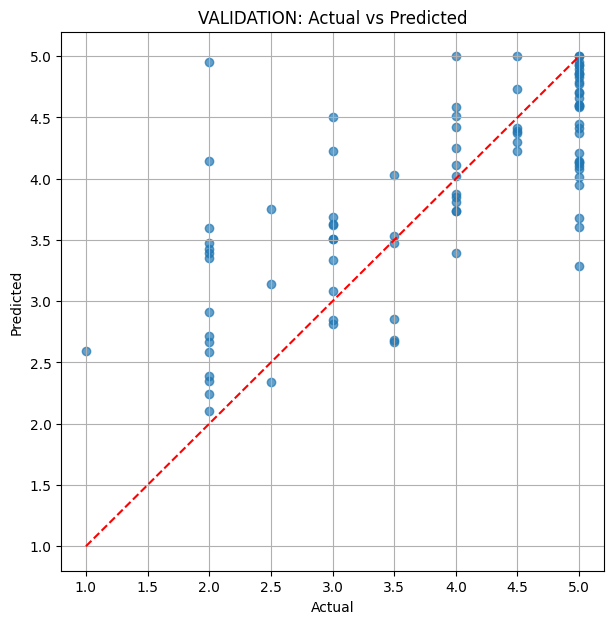

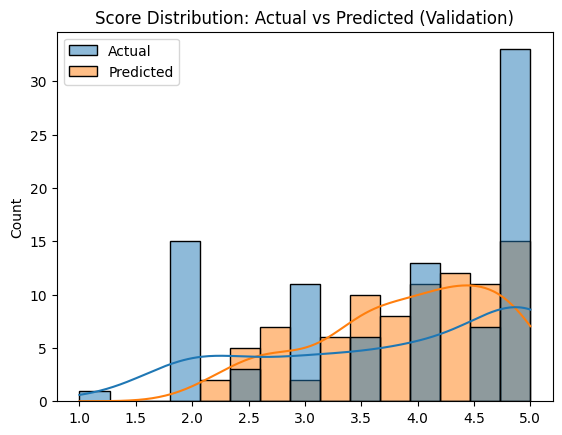

In [17]:
def print_eval(truth, pred, name=''):
    rmse = np.sqrt(mean_squared_error(truth, pred))
    pearson = pearsonr(truth, pred)[0]
    print(f"{name} RMSE: {rmse:.4f}   | {name} Pearson: {pearson:.4f}")

print_eval(y_tr, train_pred,    'TRAIN')
print_eval(y_val, val_pred,     'VALIDATION')

plt.figure(figsize=(7, 7))
plt.scatter(y_val, val_pred, alpha=0.7)
plt.xlabel('Actual'); plt.ylabel('Predicted')
plt.title('VALIDATION: Actual vs Predicted')
plt.plot([1, 5],[1, 5],'r--')
plt.grid()
plt.show()

sns.histplot({"Actual": y_val, "Predicted": val_pred}, kde=True, bins=15)
plt.title("Score Distribution: Actual vs Predicted (Validation)")
plt.show()

## 🔟 Submission

In [18]:
# Create integer label column as required
test_df['label'] = test_pred.round().astype(int)

# Save only the required columns
test_df[['filename', 'label']].to_csv('submission.csv', index=False)

print("\n--- Pipeline Finished! Submission file created as 'submission.csv' ---")


--- Pipeline Finished! Submission file created as 'submission.csv' ---


# 📝 REPORT


## Objective
The goal of this project is to develop an automated system that listens to spoken English audio, extracts grammar-related features, and predicts a grammar quality score ranging from 1 to 5 (aligning with human-annotated rubric scores). The problem is approached as a regression task.

## Approach Overview
Audio Input: Raw .wav audio files (train & test).

Feature Extraction: Three sets of features are extracted:

Acoustic features (MFCCs, chroma, ZCR, spectral centroid).

Wav2Vec2 embeddings: Deep features from a pretrained transformer model that capture high-level speech/language representations.

Meta features: Duration, energy, RMS energy, and tempo.

Data Augmentation: Strong augmentations are applied to training audio for robustness.

Modeling: Both a LightGBM regressor and an MLPRegressor are trained; their predictions are ensembled.

## Pipeline Architecture

Audio Preprocessing: Resampling, trimming, normalization.

Augmentation (train only): Noise, pitch, tempo, shift.

Feature Extraction: Acoustic + deep + meta.

Feature Scaling: StandardScaler.

Model Training: LightGBM, MLPRegressor, with ensembling.

Evaluation/Visualization: RMSE, Pearson correlation, actual vs predicted scatter/distribution plots.

Submission: CSV with test predictions.

## Results

Train RMSE/Pearson: 0.0710/0.9984

Validation RMSE/Pearson: 0.8000/0.7319

Prediction Distribution: See scatter and histogram plots; predictions closely match actual scores on validation.

Submission: Test predictions saved in correct format.